In [2]:
# calculate trigger efficiency over predictions scaled by energy (flux)
def get_true_accuracy(TP : np.ndarray, FN : np.ndarray, return_scale : bool = False) -> float : 

    x, n_e = np.loadtxt("/cr/users/filip/Binaries/energy_histogram.csv", unpack = True)
    
    # calculated in /cr/users/filip/Trigger/BuildDataset/true_efficiency.ipynb
    if not return_scale: best_efficiency = get_true_accuracy(np.array(list(TP) + list(FN)), [], return_scale = True)

    efficiency_scaled, weights = 0, 0
    n_all = len(TP) + len(FN)
    weights = 0

    for prediction in TP[:, 1]:
        idx = np.digitize(prediction, x) - 1
        weight = 100 * n_e[idx] * n_e[np.argmax(n_e)]/n_e[idx] * x[idx]**(-3) / x[np.argmin(x)]**(-3)
        efficiency_scaled += 1/(weight) * 1/n_all
        weights += weight

    efficiency_scaled *= weights * n_all

    return efficiency_scaled if return_scale else 1 - (best_efficiency - efficiency_scaled) / best_efficiency

In [1]:
from Binaries import *

percentages = [-16, -14, -13, -12, -11, -8, -6, -4, -2, -1, 0, 1, 2, 4, 8, 16]
percentages += list(np.arange(-50, -25, 5)) + list(np.arange(20, 101, 5))
percentages += list(np.arange(-95, -54, 10)) + list(np.arange(110, 251, 10))
percentages += [-94, -93, -92, -91, -90, -89, -88, -87, -86] + [-83, -81, -79, -77] + [-72, -69] + [-60]
percentages = np.array(percentages, dtype = int)

Trigger = HardwareClassifier()

In [3]:
x, y = [], []
x_true_acc = []
xerr, yerr = [], []
y_th2, y_tot, y_totd = [], [], []

for percentage in percentages:
    percentage_str = "m" if percentage < 0 else "p"
    percentage_str += str(percentage).replace('-','')

    # Accuracies
    TP, _, _, FN = Trigger.load_and_print_performance(f"production_test_{percentage_str}")
    h, o, n_all = float(len(TP)), float(len(FN)), float(len(TP) + len(FN))
    xerr.append(1/n_all**2 * np.sqrt( h**3 + o**3 - 2 * np.sqrt((h * o)**3) ))
    x.append(h / (h + o))
    x_true_acc.append(get_true_accuracy(TP, FN))

    # Rates
    t, th2, tot, tod = np.loadtxt("/cr/users/filip/Trigger/RunProductionTest/trigger_output_componentwise/nuria/nuria_all_triggers_componentwise_" + percentage_str + ".csv", unpack = True, usecols = [2,4,5,6])
    n_th2, n_tot, n_tod = th2.sum(), tot.sum(), tod.sum()

    duration = t.sum()
    y.append((n_th2 + n_tot + n_tod) / duration)
    y_th2.append(n_th2 / duration)
    y_tot.append(n_tot / duration)
    y_totd.append(n_tod / duration)
    yerr.append(1/duration * np.sqrt(n_th2 + n_tot + n_tod))



Classifier                                    Dataset                                  TP      FP      TN      FN
HardwareClassifier                            production_test_m16                  102730       0       0  143322 -> ACC =  41.75%
HardwareClassifier                            production_test_m14                  101713       0       0  144339 -> ACC =  41.34%
HardwareClassifier                            production_test_m13                  101660       0       0  144392 -> ACC =  41.32%
HardwareClassifier                            production_test_m12                  101572       0       0  144480 -> ACC =  41.28%
HardwareClassifier                            production_test_m11                  100715       0       0  145337 -> ACC =  40.93%
HardwareClassifier                            production_test_m8                    99753       0       0  146299 -> ACC =  40.54%
HardwareClassifier                            production_test_m6                    99572       0  

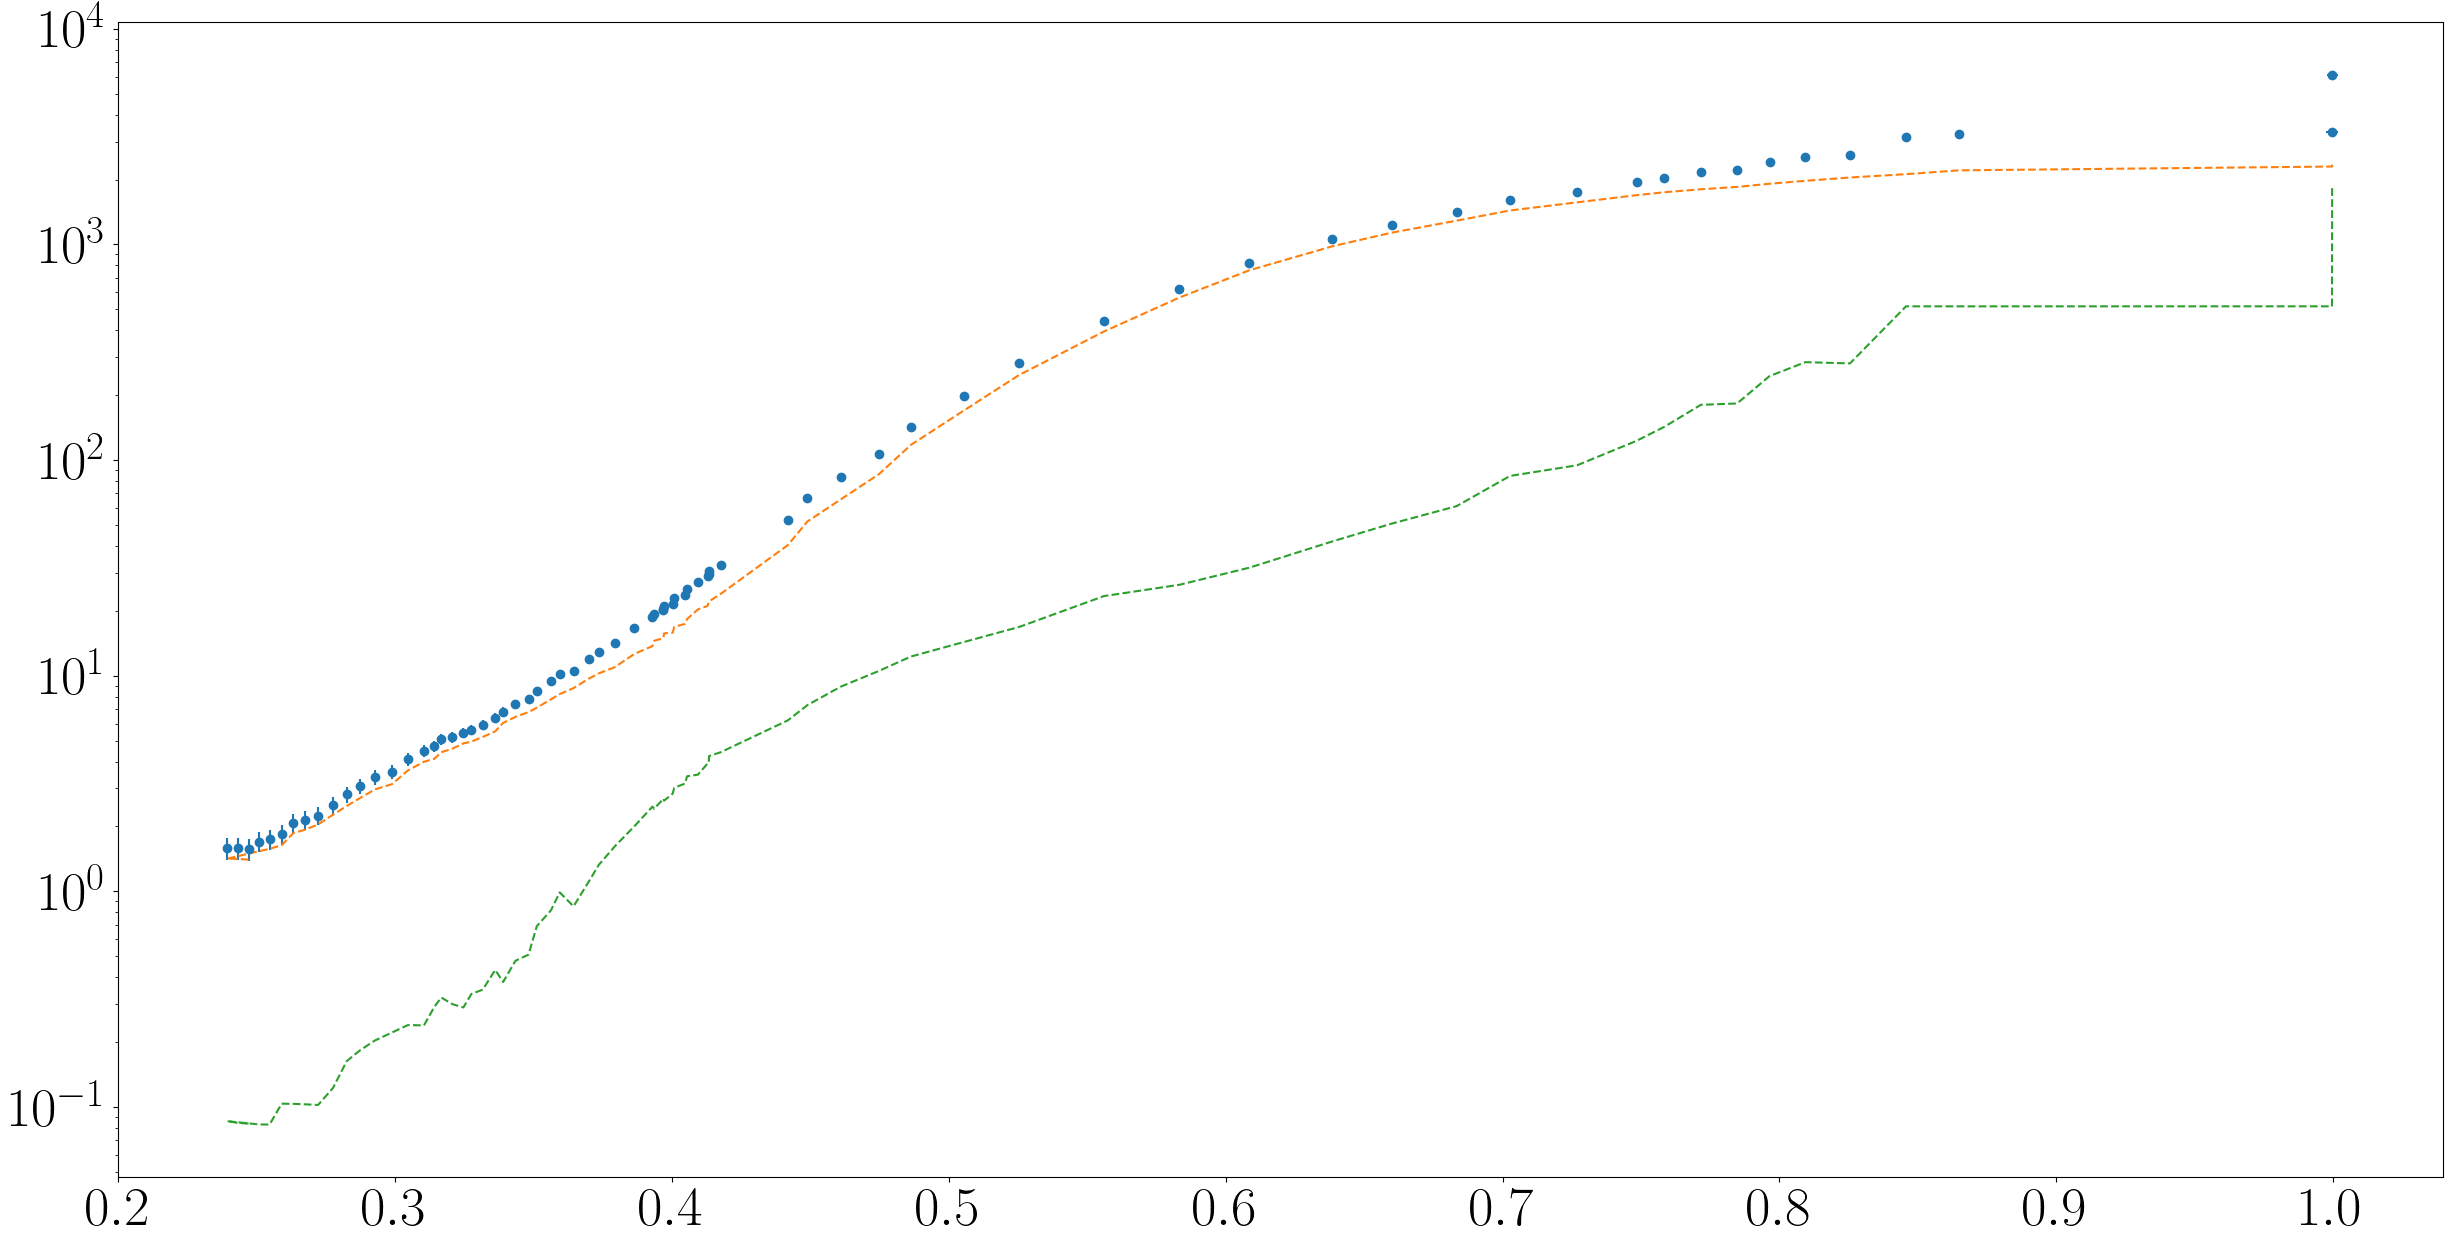

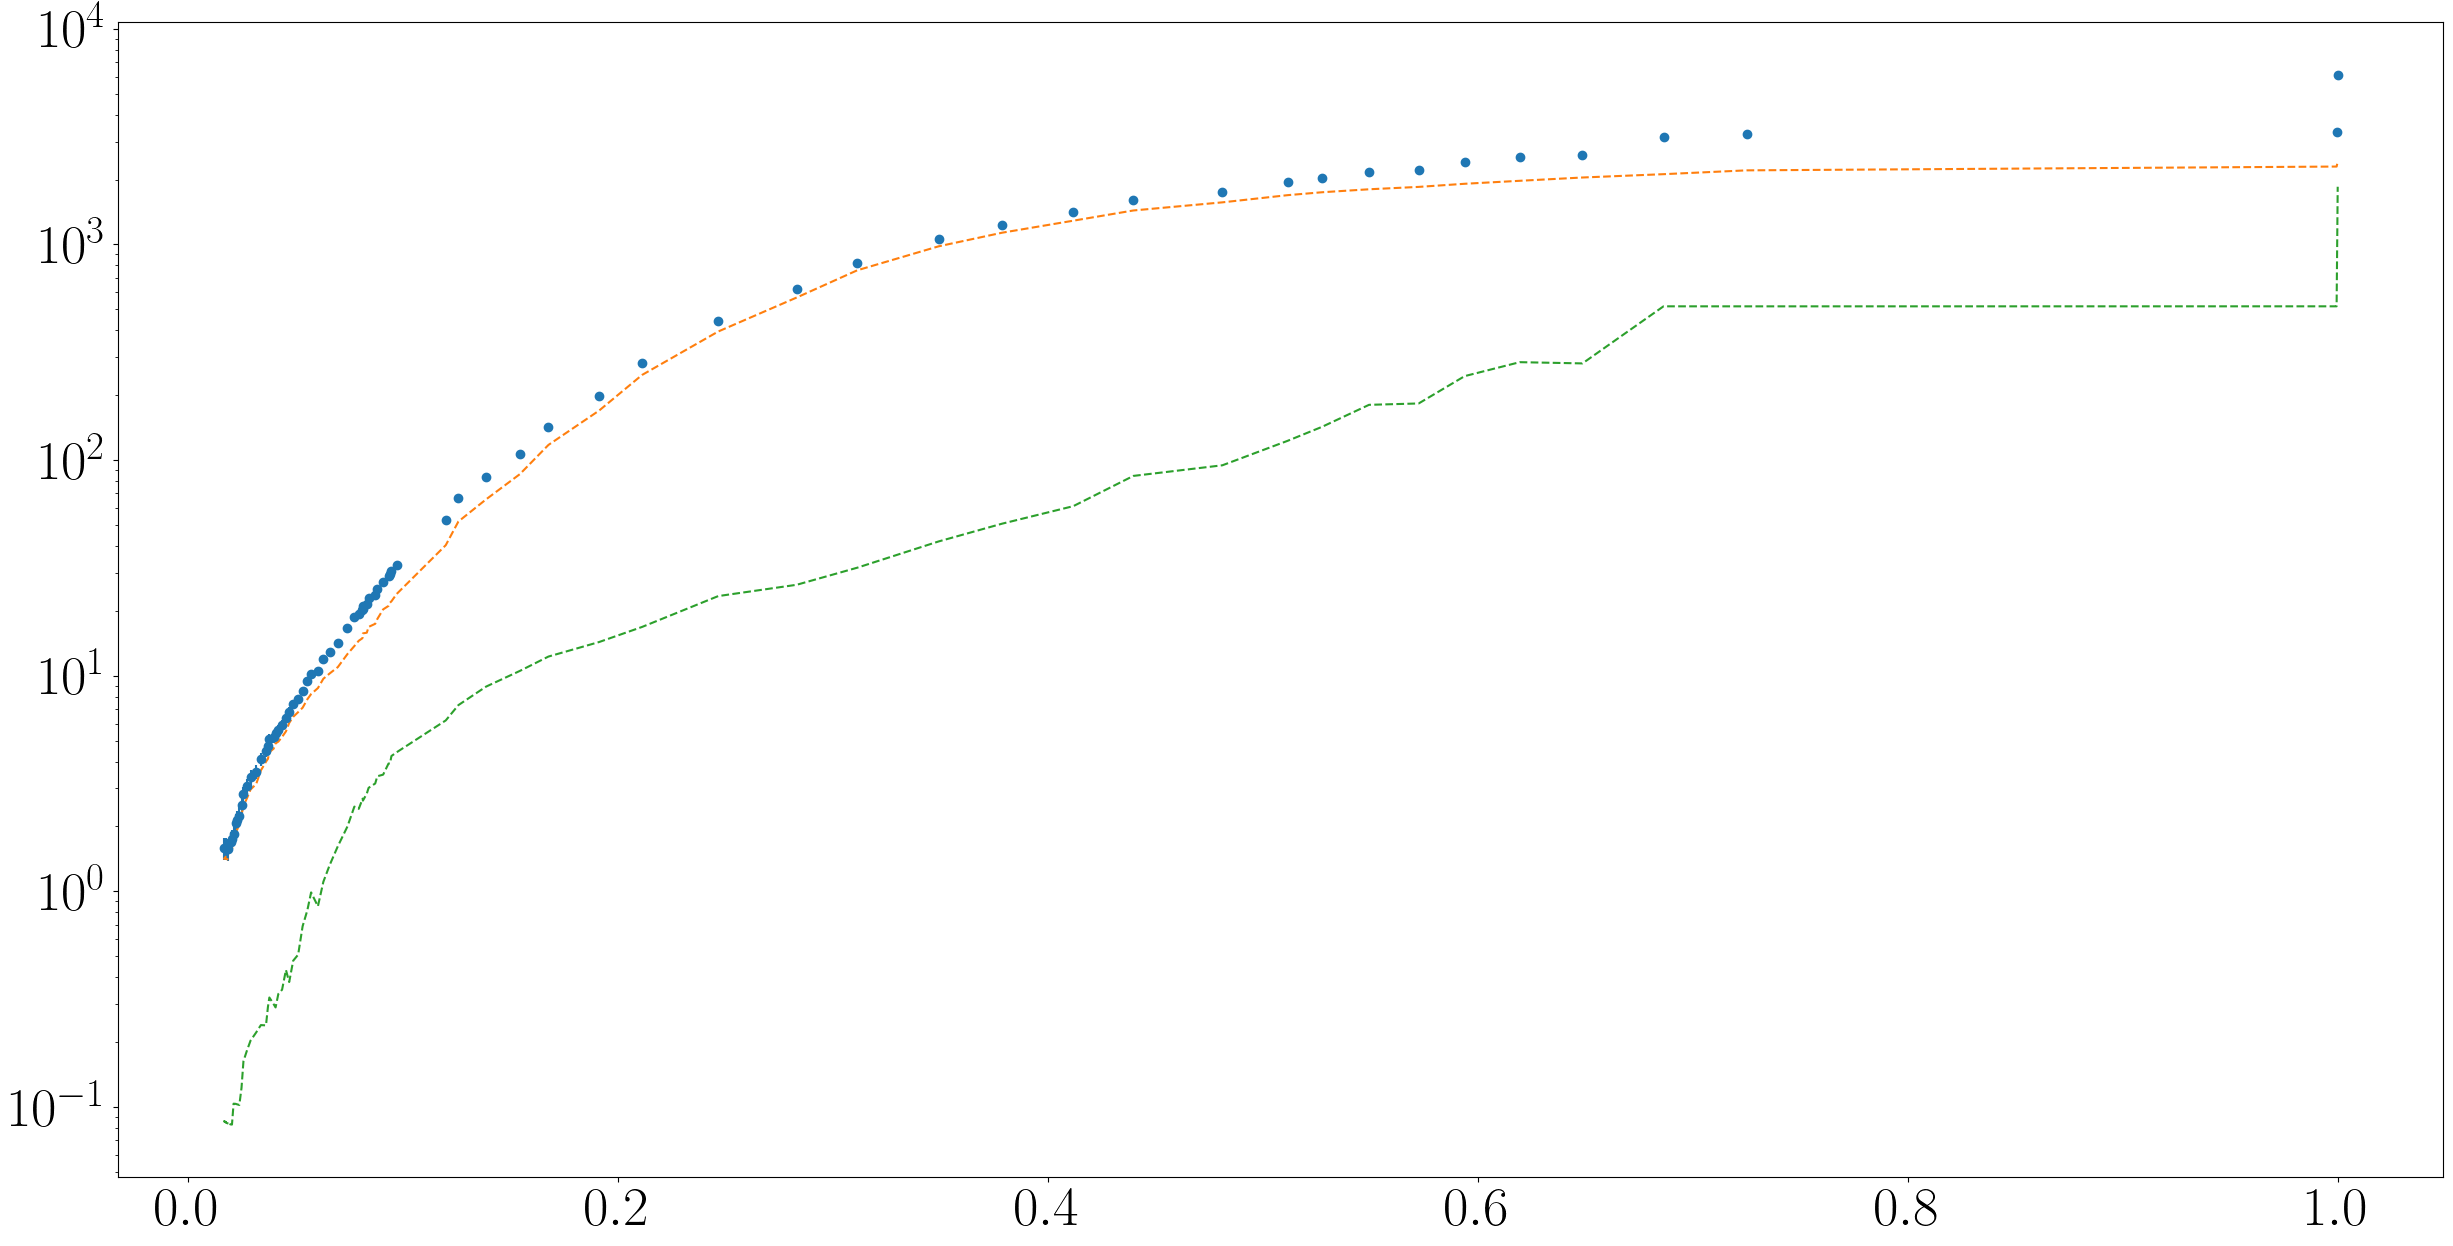

In [5]:
ii = np.argsort(y)

y = np.array(y)[ii]
x = np.array(x)[ii]
xerr = np.array(xerr)[ii]
yerr = np.array(yerr)[ii]

y_th2 = np.array(y_th2)[ii]
y_tot = np.array(y_tot)[ii]
y_totd = np.array(y_totd)[ii]
x_true_acc = np.array(x_true_acc)[ii]

save_matrix = np.dstack([x, xerr, y, yerr, y_th2, y_tot, y_totd, x_true_acc])[0]
np.savetxt("/cr/data01/filip/models/HardwareClassifier/ROC_curve/money_plot.csv", save_matrix)

plt.errorbar(x, y, xerr = xerr, yerr = yerr, fmt = "o")
plt.plot(x, y_th2, ls = "--")
plt.plot(x, y_tot, ls = "--")
# plt.plot(x, y_totd, ls = "--")

plt.yscale("log")

plt.figure()
plt.errorbar(x_true_acc, y, yerr = yerr, fmt = "o")
plt.plot(x_true_acc, y_th2, ls = "--")
plt.plot(x_true_acc, y_tot, ls = "--")
# plt.plot(x, y_totd, ls = "--")

plt.yscale("log")
# plt.xlim(min(x_true_acc), max(x_true_acc))